# Predicting shots made per game by Kobe Bryant

In this lab you'll be using regularization techniques Ridge, Lasso, and Elastic Net to try and predict well how many shots Kobe Bryant made per game in his career.

---

### 1. Load packages and data

In [1]:
import numpy as np
import pandas as pd
import patsy

from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.cross_validation import cross_val_score

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

/Users/jeremy/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [4]:
kobe = pd.read_csv('dataset/kobe_bryant/kobe_superwide_games.csv')

---

### 2. Examine the data

- How many columns are there?
- Infer what the observations (rows) and columns represent.
- Why is this data that regularization might be particularly useful for?

In [5]:
print 'Columns:', len(kobe.columns)

Columns: 645


In [13]:
print kobe.columns[0:20]


# The columns are various statistics for each game. 
# There is a column SHOTS_MADE that will be our target variable for prediction
# This is good for regularization because there are so many columns (feature selection)
# and many of the columns represent similar things (multicollinearity)

Index([u'SHOTS_MADE', u'AWAY_GAME', u'SEASON_OPPONENT:atl:1996-97',
       u'SEASON_OPPONENT:atl:1997-98', u'SEASON_OPPONENT:atl:1999-00',
       u'SEASON_OPPONENT:atl:2000-01', u'SEASON_OPPONENT:atl:2001-02',
       u'SEASON_OPPONENT:atl:2002-03', u'SEASON_OPPONENT:atl:2003-04',
       u'SEASON_OPPONENT:atl:2004-05', u'SEASON_OPPONENT:atl:2005-06',
       u'SEASON_OPPONENT:atl:2006-07', u'SEASON_OPPONENT:atl:2007-08',
       u'SEASON_OPPONENT:atl:2008-09', u'SEASON_OPPONENT:atl:2009-10',
       u'SEASON_OPPONENT:atl:2010-11', u'SEASON_OPPONENT:atl:2011-12',
       u'SEASON_OPPONENT:atl:2012-13', u'SEASON_OPPONENT:atl:2013-14',
       u'SEASON_OPPONENT:atl:2014-15'],
      dtype='object')


---

### Make predictor and target variables. Normalize the predictors.

Why is normalization necessary for regularized regressions?

There is a class in sklearn.preprocessing called `StandardScaler`. Look it up and figure out how to use it to normalize your predictor matrix. 

In [18]:
y = kobe.SHOTS_MADE.values
X = kobe.iloc[:,1:]


# Initialize the StandardScaler object
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

# use the "fit_transform" function to normalize the X design matrix
Xn = ss.fit_transform(X)

# Normalization is necessary for regularized regression because the beta
# values for each predictor variable must be on the same scale. If betas
# are different sizes just because of the scale of predictor variables
# the regularization term can't determine which betas are more/less 
# important based on their size.

<class 'sklearn.preprocessing.data.StandardScaler'>


---

### Build a linear regression predicting `SHOTS_MADE` from the rest of the columns.

Cross-validate the $R^2$ of a linear regression model with 10 cross-validation folds.

How does it perform?

In [19]:
linreg = LinearRegression()

linreg_scores = cross_val_score(linreg, Xn, y, cv=10)

print linreg_scores
print np.mean(linreg_scores)

[ -6.38038134e+28  -4.03533830e+27  -1.06501206e+28  -5.12016159e+27
  -2.44261119e+28  -1.45431869e+28  -2.64683546e+27  -1.36574776e+28
  -1.25350825e+28  -3.30557645e+28]
-1.84473892846e+28


In [7]:
# The mean R^2 is extremely negative. All the R^2 scores are negative in crossvalidation.
# The linear regression is performing far worse than baseline on the test sets.
# It is probably dramatically overfitting and the redundant variables are affecting
# the coefficients in weird ways.

---

### Find an optimal value for Ridge regression alpha using RidgeCV

[Go to the documentation and read how RidgeCV works.](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html)

Hint: once the RidgeCV is fit, the attribute `.alpha_` contains the best alpha parameter it found through cross-validation.

Recall that Ridge performs best searching alphas through logarithmic space (`np.logspace`).


In [20]:
ridge_alphas = np.logspace(0, 5, 200)

optimal_ridge = RidgeCV(alphas=ridge_alphas, cv=10)
optimal_ridge.fit(Xn, y)

print optimal_ridge.alpha_

775.259748863


---

### Cross-validate the Ridge $R^2$ with the optimal alpha.

Is it better than the Linear regression? If so, why would this be?

In [21]:
ridge = Ridge(alpha=optimal_ridge.alpha_)

ridge_scores = cross_val_score(ridge, Xn, y, cv=10)

print ridge_scores
print np.mean(ridge_scores)

[ 0.5822626   0.52880462  0.4869004   0.59583817  0.52396335  0.52942952
  0.52842192  0.41153448  0.39857643  0.44489752]
0.503062899682


In [22]:
# It's vastly better than the Linear Regression. 
# There is likely so much multicollinearity in the data that vanilla regression
# can't do anything properly. Ridge is able to manage the multicollinearity
# and get a good result.

---

### Find an optimal value for Lasso regression alpha using LassoCV

[Go to the documentation and read how LassoCV works.](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html) It is very similar to RidgeCV.

Hint: again, once the LassoCV is fit, the attribute `.alpha_` contains the best alpha parameter it found through cross-validation.

Recall that Lasso, unlike Ridge, performs best searching alphas through linear space (`np.linspace`). However, you can actually let the LassoCV decide itself what alphas to use by instead setting the keyword argument `n_alphas=` to however many alphas you want it to search over.

In [23]:
optimal_lasso = LassoCV(n_alphas=500, cv=10, verbose=1)
optimal_lasso.fit(Xn, y)

print optimal_lasso.alpha_

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

0.0679053997933


---

### Cross-validate the Lasso $R^2$ with the optimal alpha.

Is it better than the Linear regression? Is it better than Ridge? For each, why would this be?

Depending on which $R^2$ is better between the Ridge and Lasso, what can you infer about the primary issue in the data?

In [24]:
lasso = Lasso(alpha=optimal_lasso.alpha_)

lasso_scores = cross_val_score(lasso, Xn, y, cv=10)

print lasso_scores
print np.mean(lasso_scores)

[ 0.61603625  0.52641159  0.53888743  0.61322432  0.54627539  0.5554072
  0.52716822  0.44849563  0.4646267   0.51838952]
0.535492226208


In [25]:
# The lasso performs slightly better than the Ridge, but similarly.
# Lasso deals primarily with the feature selection of valuable variables,
# eliminating ones that are not useful. This also takes care of multicollinearity,
# but in a different way: it will choose the "best" of the correlated variables
# and zero-out the other redundant ones.
# There may also be useless variables in the data which it is simply getting rid
# of entirely.

---

### Look at the coefficients for variables in the Lasso.

1. Show the coefficient for variables, ordered from largest to smallest coefficient by absolute value.
2. What percent of the variables in the original dataset are "zeroed-out" by the lasso?
3. What are the most important predictors for how many shots kobe made in a game?

Note: if you only fit the Lasso within cross_val_score, you will have to refit it outside of that
function to pull out the coefficients.

In [26]:
lasso.fit(Xn, y)

Lasso(alpha=0.067905399793263543, copy_X=True, fit_intercept=True,
   max_iter=1000, normalize=False, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [30]:
lasso_coefs = pd.DataFrame({'variable':X.columns,
                            'coef':lasso.coef_,
                            'abs_coef':np.abs(lasso.coef_)})

lasso_coefs.sort_values('abs_coef', inplace=True, ascending=False)

lasso_coefs.head(20)



TypeError: 'tuple' object is not callable

In [31]:
print 'Percent variables zeroed out:', np.sum((lasso.coef_ == 0))/float(X.shape[0])

Percent variables zeroed out: 0.326059050064


---

### Find an optimal value for Elastic Net regression alpha using ElasticNetCV

[Go to the documentation and read how LassoCV works.](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNetCV.html).

Note here that you will be optimizing both the alpha parameter and the l1_ratio:

    alpha: strength of regularization
    l1_ratio: amount of ridge vs. lasso (0 = all ridge, 1 = all lasso)
    
Do not include 0 in the search for l1_ratio: it will not allow it and break!

You can use n_alphas for the alpha parameters instead of setting your own values: highly recommended!

Also - be careful setting too many l1_ratios over cross-validation folds in your search. It can take a very long time if you choose too many combinations and for the most part there are diminishing returns in this data.

In [33]:
l1_ratios = np.linspace(0.01, 1.0, 50)

optimal_enet = ElasticNetCV(l1_ratio=l1_ratios, n_alphas=300, cv=5,
                            verbose=1)
optimal_enet.fit(Xn, y)

print optimal_enet.alpha_
print optimal_enet.l1_ratio_


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

0.0592140326165
0.979795918367


---

### Cross-validate the ElasticNet $R^2$ with the optimal alpha and l1_ratio.

How does it compare to the other regularized regressions?

In [34]:
enet = ElasticNet(alpha=optimal_enet.alpha_, l1_ratio=optimal_enet.l1_ratio_)

enet_scores = cross_val_score(enet, Xn, y, cv=10)

print enet_scores
print np.mean(enet_scores)

[ 0.62407863  0.52647017  0.5373568   0.61545993  0.54373335  0.55483683
  0.53007979  0.44711827  0.46384224  0.51060689]
0.535358290358


---

### Plot the residuals for the ridge, lasso, and elastic net on histograms

This is another way to look at the performance of your model.

The tighter the distribution of residuals around zero, the better your model has performed!

In [35]:
# Need to fit the ElasticNet and Ridge outside of cross_val_score like i did with the ridge
ridge.fit(Xn, y)
enet.fit(Xn, y)
lasso.fit(Xn, y)

Lasso(alpha=0.067905399793263543, copy_X=True, fit_intercept=True,
   max_iter=1000, normalize=False, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [36]:
# model residuals:

ridge_resid = y - ridge.predict(Xn)
lasso_resid = y - lasso.predict(Xn)
enet_resid = y - enet.predict(Xn)


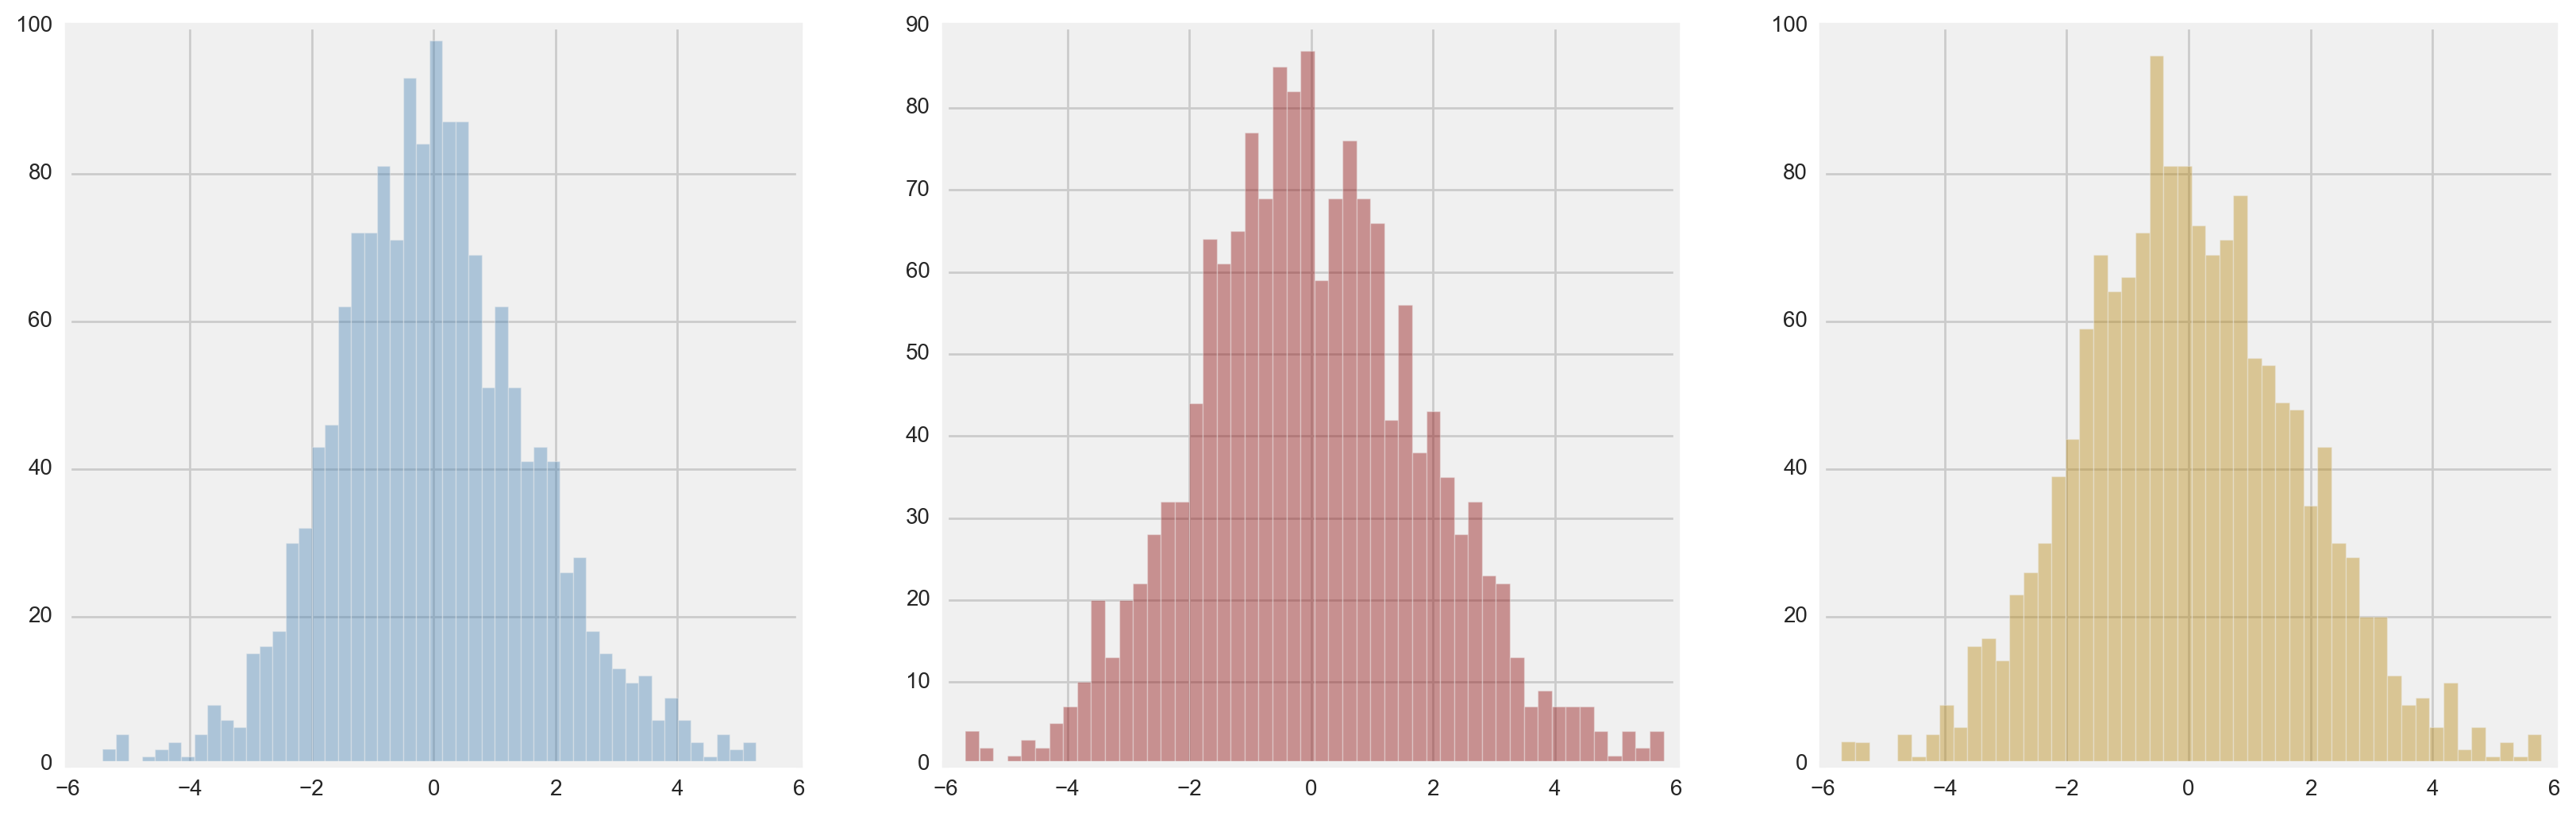

In [38]:
fig, axarr = plt.subplots(1, 3, figsize=(18, 6))

sns.distplot(ridge_resid, bins=50, hist=True, kde=False, 
             color='steelblue', ax=axarr[0], label='Ridge residuals')


sns.distplot(lasso_resid, bins=50, hist=True, kde=False, 
             color='darkred', ax=axarr[1], label='Lasso residuals')


sns.distplot(enet_resid, bins=50, hist=True, kde=False, 
             color='darkgoldenrod', ax=axarr[2], label='ElasticNet residuals')


plt.show()
